<a href="https://colab.research.google.com/github/armandoalbornoz/replicating_paper/blob/main/Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pytorch Model Deployment

## Get Data

We are going to use the 20% pizza, steak, sushi dataset.

In [1]:
# Setup
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1457), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting Data

In [3]:

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path


[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## Experiments

We are going to build two models:

1. EffNetB2 feature extractor
2. ViT feature extractor

Our goal is to pick a model that is both fast and accurate.

## Creating EffNetB2 feature extractor



In [5]:
# Get pretrained model and transforms
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

# Freeze base layers
for param in effnetb2.features.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 223MB/s]


In [6]:
from torchinfo import summary

summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=3,
              bias=True)).to(device)

In [9]:
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [10]:
def create_effnetb2_model(num_classes=3):

  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = effnetb2_weights.transforms()
  effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

  # Freeze base layers
  for param in effnetb2.features.parameters():
      param.requires_grad = False

  effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=num_classes,
              bias=True)).to(device)

  return effnetb2, transforms

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model(3)

In [12]:
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Creating Dataloaders for EffNetB2



In [13]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

## Training EffNetB2 feature extractor

In [14]:
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [15]:
from going_modular.going_modular import engine

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9795 | train_acc: 0.5271 | test_loss: 0.7368 | test_acc: 0.8983
Epoch: 2 | train_loss: 0.7443 | train_acc: 0.7521 | test_loss: 0.5891 | test_acc: 0.9290
Epoch: 3 | train_loss: 0.5834 | train_acc: 0.8458 | test_loss: 0.5084 | test_acc: 0.9506
Epoch: 4 | train_loss: 0.5201 | train_acc: 0.8875 | test_loss: 0.4455 | test_acc: 0.9443
Epoch: 5 | train_loss: 0.4221 | train_acc: 0.9062 | test_loss: 0.3919 | test_acc: 0.9534
Epoch: 6 | train_loss: 0.3804 | train_acc: 0.9208 | test_loss: 0.3577 | test_acc: 0.9443
Epoch: 7 | train_loss: 0.3469 | train_acc: 0.9354 | test_loss: 0.3320 | test_acc: 0.9381
Epoch: 8 | train_loss: 0.3446 | train_acc: 0.8896 | test_loss: 0.3159 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3898 | train_acc: 0.8938 | test_loss: 0.3080 | test_acc: 0.9500
Epoch: 10 | train_loss: 0.2859 | train_acc: 0.9333 | test_loss: 0.2895 | test_acc: 0.9381


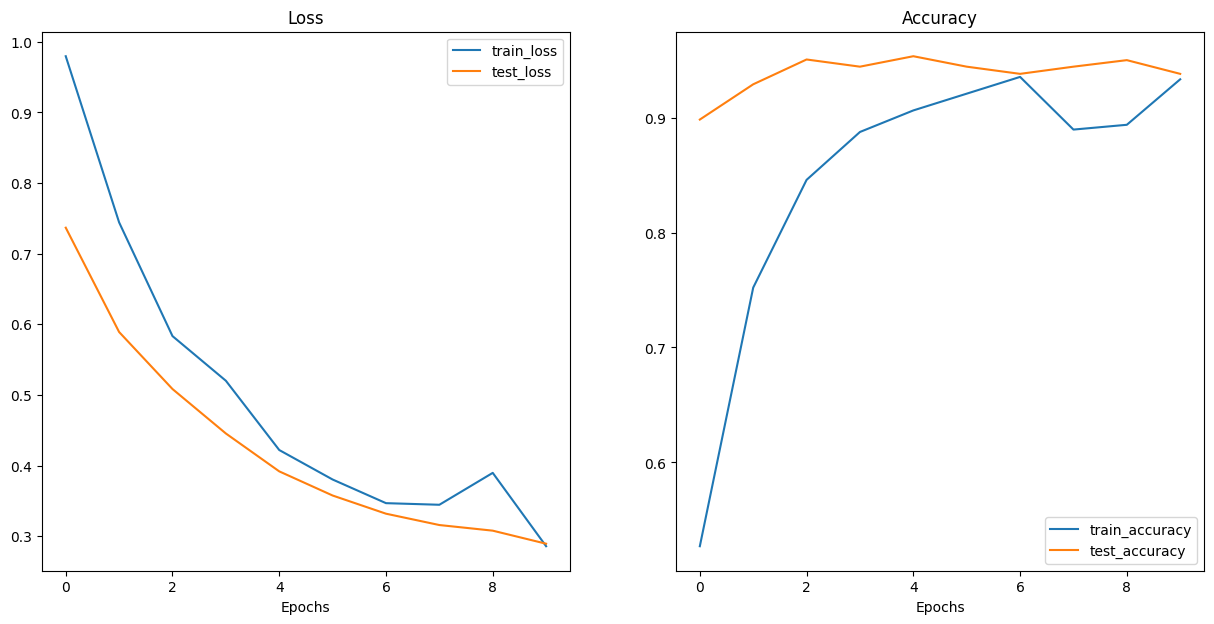

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

## Saving EffNetB2 feature extractor

In [17]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth


### Inspecting size of model

In [18]:
from pathlib import Path

model_path = Path("models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth")
model_size_mb = model_path.stat().st_size / (1024 * 1024)
print(f"Model size: {model_size_mb:.2f} MB")

Model size: 29.85 MB


## Collecting EffNetB2 properties

In [19]:
# Count the number of parameters
total_params = sum(torch.numel(param) for param in effnetb2.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 7705221


In [20]:
# Create a dictionary with the statistics

effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters" : total_params ,
                  "model_size (MB)" :model_size_mb
                  }

In [21]:
effnetb2_stats

{'test_loss': 0.28947691321372987,
 'test_acc': 0.9380681818181819,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8526554107666}

## Creating the ViT model

In [22]:
def create_vit_model(num_classes=3):

  vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = vit_weights.transforms()
  vit = torchvision.models.vit_b_16(weights=vit_weights).to(device)

  # Freeze base layers
  for param in vit.parameters():
      param.requires_grad = False

  vit.heads


  vit.heads = nn.Sequential(
    nn.Linear(in_features=768,
              out_features=num_classes,
              bias=True)).to(device)

  return vit, transforms

In [23]:
vit, vit_transforms = create_vit_model(3)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 227MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## Creating Dataloaders

In [24]:
# Creating Dataloaders for vit

from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

## Vit Training

In [25]:
optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [26]:
from going_modular.going_modular import engine

vit_results = engine.train(model=vit,
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6309 | train_acc: 0.7896 | test_loss: 0.2470 | test_acc: 0.9659
Epoch: 2 | train_loss: 0.2150 | train_acc: 0.9500 | test_loss: 0.1254 | test_acc: 0.9659
Epoch: 3 | train_loss: 0.1475 | train_acc: 0.9583 | test_loss: 0.0936 | test_acc: 0.9659
Epoch: 4 | train_loss: 0.1205 | train_acc: 0.9625 | test_loss: 0.0786 | test_acc: 0.9812
Epoch: 5 | train_loss: 0.1011 | train_acc: 0.9688 | test_loss: 0.0722 | test_acc: 0.9938
Epoch: 6 | train_loss: 0.0861 | train_acc: 0.9750 | test_loss: 0.0658 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0764 | train_acc: 0.9812 | test_loss: 0.0632 | test_acc: 0.9938
Epoch: 8 | train_loss: 0.0641 | train_acc: 0.9875 | test_loss: 0.0585 | test_acc: 0.9938
Epoch: 9 | train_loss: 0.0576 | train_acc: 0.9917 | test_loss: 0.0569 | test_acc: 0.9875
Epoch: 10 | train_loss: 0.0518 | train_acc: 0.9938 | test_loss: 0.0544 | test_acc: 0.9938


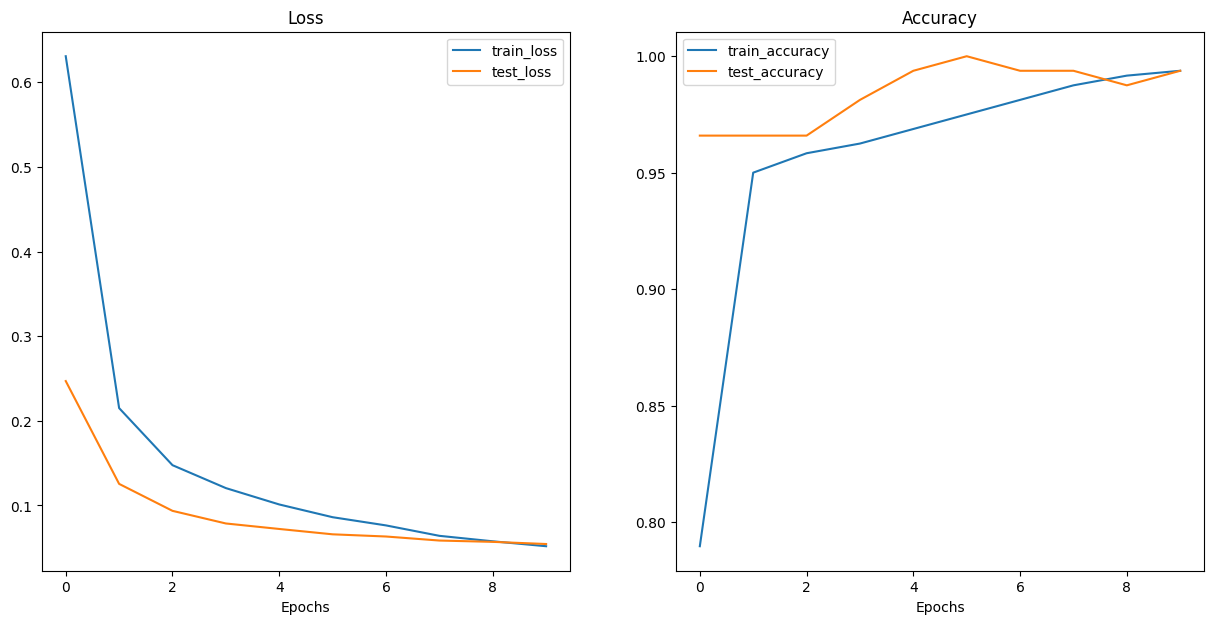

In [27]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

## Saving Vit Model

In [28]:
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="pretrained_vit_b_16_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/pretrained_vit_b_16_feature_extractor_pizza_steak_sushi.pth


## Inspecting size of model


In [29]:
from pathlib import Path

model_path = Path("models/pretrained_vit_b_16_feature_extractor_pizza_steak_sushi.pth")
model_size_mb = model_path.stat().st_size / (1024 * 1024)
print(f"Model size: {model_size_mb:.2f} MB")

Model size: 327.37 MB


## Collecting Vit feuature extractor properties

In [30]:
# Count the number of parameters
total_params = sum(torch.numel(param) for param in vit.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 85800963


In [31]:
# Create a dictionary with the statistics

vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "number_of_parameters" : total_params ,
                  "model_size (MB)" :model_size_mb
                  }

In [32]:
vit_stats

{'test_loss': 0.05437586451880634,
 'test_acc': 0.99375,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3695697784424}

## Making predictions with our models and timing them

In [33]:
from pathlib import Path

# get all test data paths

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:10]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/595836.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1302563.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/697562.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/219196.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3553838.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/289822.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/730464.jpg')]

In [34]:
## Let's create a function that makes predictionss across the dataset

import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  pred_list = []

  # Loop through the paths

  for path in tqdm(paths):
    # Create an dictionary for each sample
    pred_dict = {}

    # Get the sample path and label frrom the filepath
    pred_dict["image_path"] = path
    class_name = path.parent.name
    pred_dict["class_name"] = class_name

    # Start the prediction timer
    start_time= timer()

    img = Image.open(path)

    transformed_img = transform(img).unsqueeze(0).to(device) # We also add a batch dimension

    model = model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logits = model(transformed_img)
      pred_probs = torch.softmax(pred_logits, dim=1)
      pred_label = torch.argmax(pred_probs, dim=1)
      pred_class = class_names[pred_label.cpu()] # harcode prediction class to be on CPU (Python variables live on CPU)


      pred_dict["pred_prob"] = round(pred_probs.max().item(), 4)
      pred_dict["pred_class"] =  pred_class

      end_timer = timer()
      pred_dict["prediction_time"] = round(end_timer - start_time, 4)

    pred_dict["correct"] = class_name == pred_class

    pred_list.append(pred_dict)

  return pred_list

## EffnetB2 making and timing predictions

1. Our predictions will happen on the CPU since not all devices have a GPU.




In [35]:
effnetb2_test_predictions = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [36]:
effnetb2_test_predictions[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/595836.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7326,
  'pred_class': 'steak',
  'prediction_time': 0.2181,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1285886.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8746,
  'pred_class': 'steak',
  'prediction_time': 0.0527,
  'correct': True}]

In [37]:
# Turn the list of dictionaries into a dataframe

import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_predictions)
effnetb2_test_pred_df

,image_path,class_name,pred_prob,pred_class,prediction_time,correct
0,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.7326,steak,0.2181,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8746,steak,0.0527,True
2,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9859,steak,0.0529,True
3,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.9544,steak,0.0525,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.5946,steak,0.0503,True
...,...,...,...,...,...,...
145,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.8323,pizza,0.0497,True
146,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9758,pizza,0.0540,True
147,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9075,pizza,0.0588,True
148,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.9472,pizza,0.0494,True


In [38]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,141
False,9


In [39]:
# Let's find the average time per prediction

effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.prediction_time.mean(), 4)
effnetb2_average_time_per_pred

np.float64(0.0528)

## ViT making and timing predictions


In [40]:
vit_test_predictions = pred_and_store(paths=test_data_paths,
                                          model=vit,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [41]:
vit_test_predictions[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/595836.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9614,
  'pred_class': 'steak',
  'prediction_time': 0.2775,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1285886.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9705,
  'pred_class': 'steak',
  'prediction_time': 0.0926,
  'correct': True}]

In [42]:
# Turn the list of dictionaries into a dataframe

import pandas as pd

vit_test_pred_df = pd.DataFrame(vit_test_predictions)
vit_test_pred_df

,image_path,class_name,pred_prob,pred_class,prediction_time,correct
0,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.9614,steak,0.2775,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9705,steak,0.0926,True
2,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9935,steak,0.0926,True
3,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.8817,steak,0.0908,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9959,steak,0.0950,True
...,...,...,...,...,...,...
145,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9986,pizza,0.1215,True
146,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9976,pizza,0.1251,True
147,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9958,pizza,0.1258,True
148,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.9943,pizza,0.1264,True


In [43]:
# Check number of correct predictions
vit_test_pred_df.correct.value_counts()

,count
correct,
True,149
False,1


In [44]:
# Let's find the average time per prediction

vit_average_time_per_pred = round(vit_test_pred_df.prediction_time.mean(), 4)
vit_average_time_per_pred

np.float64(0.1254)

In [45]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred

## Comparing model results, prediction time and size of the models

In [46]:
df = pd.DataFrame([effnetb2_stats, vit_stats])
df["model"] = ["EffNetB2", "ViT"]
df["test_acc"] = round(df["test_acc"] * 100, 2 )
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.289477,93.81,7705221,29.852655,0.0528,EffNetB2
1,0.054376,99.38,85800963,327.369570,0.1254,ViT


# Ratio Comparisons

In [47]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.187842,1.059375,11.135432,10.966179,2.375


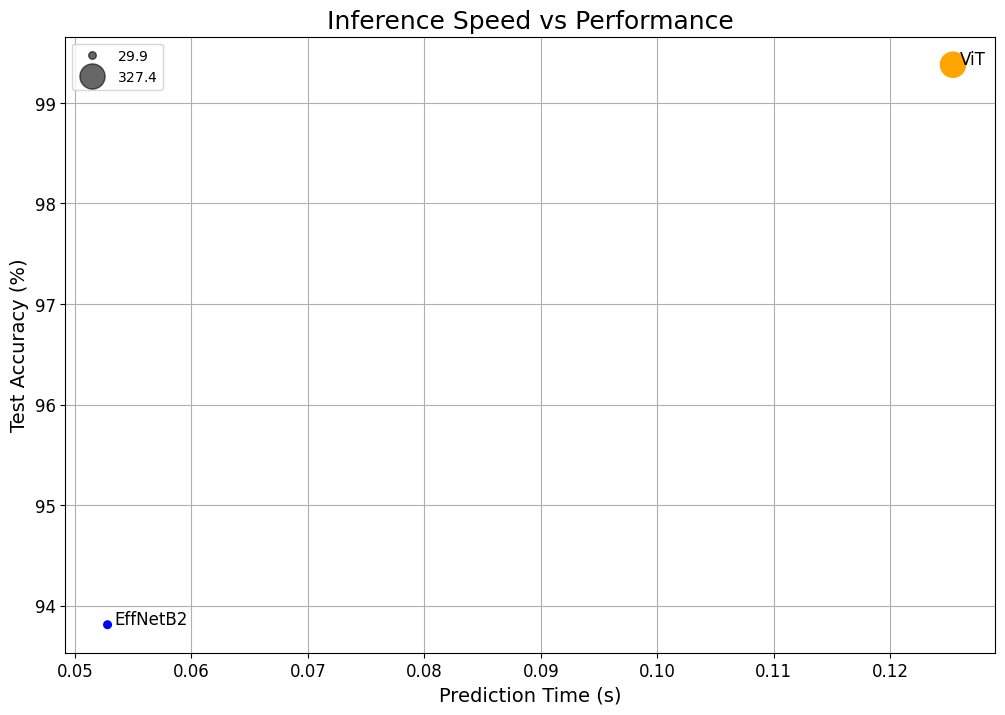

In [48]:
fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data=df, x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

ax.set_title("Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction Time (s)", fontsize=14)
ax.set_ylabel("Test Accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
  ax.annotate(text=row["model"],
              xy=(row["time_per_pred_cpu"] + 0.0006, row["test_acc"] + 0.003),
              size=12)

  handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
  model_size_legend = ax.legend(handles, labels, loc="upper left")

  ## Save the figure
 # plt.savefig("./images/inference_speed_vs_performance.png")

## We will deploy Effnet Using Gradio

In [49]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 5.31.0


In [50]:
effnetb2 = effnetb2.to("cpu")

next(iter(effnetb2.parameters())).device

device(type='cpu')

In [51]:
# Let's create a function that receives an image, and makes a prediction of one of our labels based on that image. It also returns the prediction time

from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  # Timer logic
  start_time = timer()
  img = effnetb2_transforms(img).unsqueeze(0) # adds batch dimension

  effnetb2.eval()
  with torch.inference_mode():
    pred_logits = effnetb2(img)
    pred_probs = torch.softmax(pred_logits, dim=1)

  pred_labels_and_probs = {class_names[i] : float(pred_probs[0][i]) for i in range(len(class_names))}

  pred_time = round(timer() - start_time, 5)

  return pred_labels_and_probs, pred_time

  # Transform input image
  image_transform = effnetb2.transform

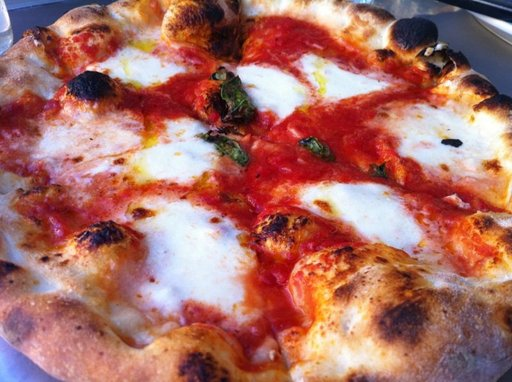

In [52]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[0]

# Select random path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open image
img = Image.open(random_image_path)
img


In [53]:
print(f" [INFO] Predicting on image at path {random_image_path}")
pred_dict, pred_time = predict(img=img)
pred_dict, pred_time

 [INFO] Predicting on image at path data/pizza_steak_sushi_20_percent/test/pizza/380739.jpg


({'pizza': 0.9476308226585388,
  'steak': 0.016383245587348938,
  'sushi': 0.03598587587475777},
 0.05243)

## Creating Example Images

In [54]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/746921.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/3227791.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/552171.jpg']]

In [55]:
import gradio as gr

# Create Title, description and article

title = "Sushi, Steak and Pizza Classification with PyTorch and EfficientNetB2"
description  = "An EfficientNetB2 feature extractor."

## Create demo

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description)

demo.launch(debug=False, share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5b362558e1ca7c659a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Turning our Gradio demo into a deployable app

### Deployed demo structure

In [56]:
# Create a demos folder to store out app files

In [57]:
import shutil
from pathlib import Path

demo_path = Path("demos/sushi_pizza_steak_effnetb2_gradio/")

if demo_path.exists():
  shutil.rmtree(demo_path)
  demo_path.mkdir(parents=True, exist_ok=True)
else:
  demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/sushi_pizza_steak_effnetb2_gradio

# Creating examples folder

In [58]:
# Create an examples directory

examples_path = demo_path / "examples"
examples_path.mkdir(parents=True, exist_ok=True)

examples = [Path('data/pizza_steak_sushi_20_percent/test/steak/3479599.jpg'),
            Path('data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg'),
            Path('data/pizza_steak_sushi_20_percent/test/pizza/380739.jpg')]

for example in examples:
  destination_path = examples_path / example.name
  print(f"[INFO] Copying {example} to {destination_path}")
  shutil.copy2(src=example, dst=destination_path)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3479599.jpg to demos/sushi_pizza_steak_effnetb2_gradio/examples/3479599.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg to demos/sushi_pizza_steak_effnetb2_gradio/examples/2353677.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/380739.jpg to demos/sushi_pizza_steak_effnetb2_gradio/examples/380739.jpg


Let's verify we can get a list of lists from `examples` since that is the format gradio expects

In [59]:
import os

example_list = [["examples/" + example] for example in os.listdir(examples_path)]
example_list

[['examples/3479599.jpg'], ['examples/380739.jpg'], ['examples/2353677.jpg']]

In [60]:
import shutil

# Create a source path for our model
effnetb2_model_path = "models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth"

# Create destination path
effnetb2_model_destination = demo_path /effnetb2_model_path.split("/")[1]

# Move model file

try:
  print("[INFO] Moving model file")
  shutil.move(src=effnetb2_model_path, dst=effnetb2_model_destination)
  print("[INFO] Model move complete")
except:
  print("[INFO] Model file already moved")

[INFO] Moving model file
[INFO] Model move complete


## Turning off EffNetB2 model into a Python script

In [61]:
%%writefile demos/sushi_pizza_steak_effnetb2_gradio//model.py

import torch
from torch import nn
import torchvision

def create_effnetb2_model(num_classes=3, device="cpu"):

  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = effnetb2_weights.transforms()
  effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

  # Freeze base layers
  for param in effnetb2.features.parameters():
      param.requires_grad = False

  effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=num_classes,
              bias=True)).to(device)

  return effnetb2, transforms

Writing demos/sushi_pizza_steak_effnetb2_gradio//model.py


In [62]:
import importlib
from demos.sushi_pizza_steak_effnetb2_gradio import model
importlib.reload(model)

effnetb2, effnetb2_transforms = model.create_effnetb2_model(device=device)

## Making the gradio app into a Python script

In [63]:
%%writefile demos/sushi_pizza_steak_effnetb2_gradio/app.py

# imports
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer
from typing import Tuple, Dict

class_names = ['pizza', 'steak', 'sushi']

effnetb2, effnetb2_transforms = create_effnetb2_model()

# load weights
effnetb2.load_state_dict(
    torch.load(
        f="pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth",
        map_location=torch.device("cpu"), # load model to cpu

    )
)

# predict function
# Let's create a function that receives an image, and makes a prediction of one of our labels based on that image. It also returns the prediction time

def predict(img) -> Tuple[Dict, float]:
  # Timer logic
  start_time = timer()
  img = effnetb2_transforms(img).unsqueeze(0) # adds batch dimension

  effnetb2.eval()
  with torch.inference_mode():
    pred_logits = effnetb2(img)
    pred_probs = torch.softmax(pred_logits, dim=1)

  pred_labels_and_probs = {class_names[i] : float(pred_probs[0][i]) for i in range(len(class_names))}

  pred_time = round(timer() - start_time, 5)

  return pred_labels_and_probs, pred_time


example_list = [["examples/" + example] for example in os.listdir("examples")]


## Gradio app

# Create Title, description

title = "Sushi, Steak and Pizza Classification with PyTorch and EfficientNetB2"
description  = "An EfficientNetB2 feature extractor."

## Create demo

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description)

demo.launch(debug=False, share=True)


Writing demos/sushi_pizza_steak_effnetb2_gradio/app.py


## Creating requirements.txt

In [64]:
%%writefile demos/sushi_pizza_steak_effnetb2_gradio/requirements.txt
torch==2.6.0
torchvision==0.21
gradio==5.31.0

Writing demos/sushi_pizza_steak_effnetb2_gradio/requirements.txt


## Deploying to Hugginface

In [65]:
!ls demos/sushi_pizza_steak_effnetb2_gradio/

app.py	  pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth
examples  __pycache__
model.py  requirements.txt


In [66]:
!cd demos/sushi_pizza_steak_effnetb2_gradio && zip -r ../sushi_pizza_steak_effnetb2_gradio.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 53%)
  adding: examples/ (stored 0%)
  adding: examples/3479599.jpg (deflated 1%)
  adding: examples/380739.jpg (deflated 0%)
  adding: examples/2353677.jpg (deflated 0%)
  adding: model.py (deflated 49%)
  adding: pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


In [67]:
# Download
try:
  from google.colab import files
  files.download("demos/sushi_pizza_steak_effnetb2_gradio.zip")
except:
  print("[INFO] Not running on Google Colab")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Uploading to Spaces

In [68]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame
# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/abel31416/food_classifier/+", width=900, height=750)

# Let's increase the number of classes

In [69]:
effnetb2_food101, effbetb2_transform =create_effnetb2_model(num_classes=101)

from torchinfo import summary

summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [70]:
# train data transform
food101_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

food101_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [71]:
test_data_transform = effnetb2_transforms

# Get data

In [72]:
from torchvision import datasets
from pathlib import Path

data_dir = Path("data")

train_data = datasets.Food101(root=data_dir,
                              split="train",
                              download=True,
                              transform=food101_transforms)

test_data = datasets.Food101(root=data_dir,
                             split="test",
                             download=True,
                             transform=test_data_transform)

100%|██████████| 5.00G/5.00G [05:17<00:00, 15.7MB/s]


In [73]:
food101_class_names = train_data.classes
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Subset of food101

We want our experiments to run quickly so let's first just use a subset of the data, and if everything works fine we can use the whole dataset.

Goal: beat the original Food101 paper result of 56.4% accuracy on the test dataset.

In [74]:
from torch.utils.data import random_split

def split_dataset(dataset: torchvision.datasets,
                  split_size: float=0.2,
                  seed: int=42):

  # Create split lenghths
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1

  print(f"[INFO] Splitting dataset of length {len(dataset)} into {length_1} and {length_2}")

  # Create splits
  split_1, split_2 = random_split(dataset=dataset, lengths=[length_1, length_2], generator=torch.manual_seed(seed))

  return split_1, split_2

In [75]:
train_data_20, _ = split_dataset(dataset=train_data, split_size=0.2)
test_data_20, _ = split_dataset(dataset=test_data, split_size=0.2)

[INFO] Splitting dataset of length 75750 into 15150 and 60600
[INFO] Splitting dataset of length 25250 into 5050 and 20200


In [76]:
len(train_data_20), len(test_data_20)

(15150, 5050)

## Turning the datasets into dataloaders

In [77]:
import os
BATCH_SIZE = 32


train_dataloader_20 = torch.utils.data.DataLoader(dataset=train_data_20,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  num_workers=os.cpu_count())

test_dataloader_20 = torch.utils.data.DataLoader(dataset=test_data_20,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 num_workers=os.cpu_count())


In [78]:
len(train_dataloader_20)

474

## Training The Model


In [80]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds()

effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_20,
                                        test_dataloader=test_dataloader_20,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=10,
                                        device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3813 | train_acc: 0.5662 | test_loss: 2.3491 | test_acc: 0.5594
Epoch: 2 | train_loss: 2.3198 | train_acc: 0.5809 | test_loss: 2.3302 | test_acc: 0.5649
Epoch: 3 | train_loss: 2.4659 | train_acc: 0.5331 | test_loss: 2.2889 | test_acc: 0.5764
Epoch: 4 | train_loss: 2.4700 | train_acc: 0.5269 | test_loss: 2.2684 | test_acc: 0.5769
Epoch: 5 | train_loss: 2.4356 | train_acc: 0.5411 | test_loss: 2.2599 | test_acc: 0.5794
Epoch: 6 | train_loss: 2.4070 | train_acc: 0.5450 | test_loss: 2.2601 | test_acc: 0.5853
Epoch: 7 | train_loss: 2.3700 | train_acc: 0.5530 | test_loss: 2.2308 | test_acc: 0.5857
Epoch: 8 | train_loss: 2.3547 | train_acc: 0.5615 | test_loss: 2.2283 | test_acc: 0.5932
Epoch: 9 | train_loss: 2.3455 | train_acc: 0.5640 | test_loss: 2.2261 | test_acc: 0.5946
Epoch: 10 | train_loss: 2.3342 | train_acc: 0.5650 | test_loss: 2.2400 | test_acc: 0.5880


## Inspecting loss curves

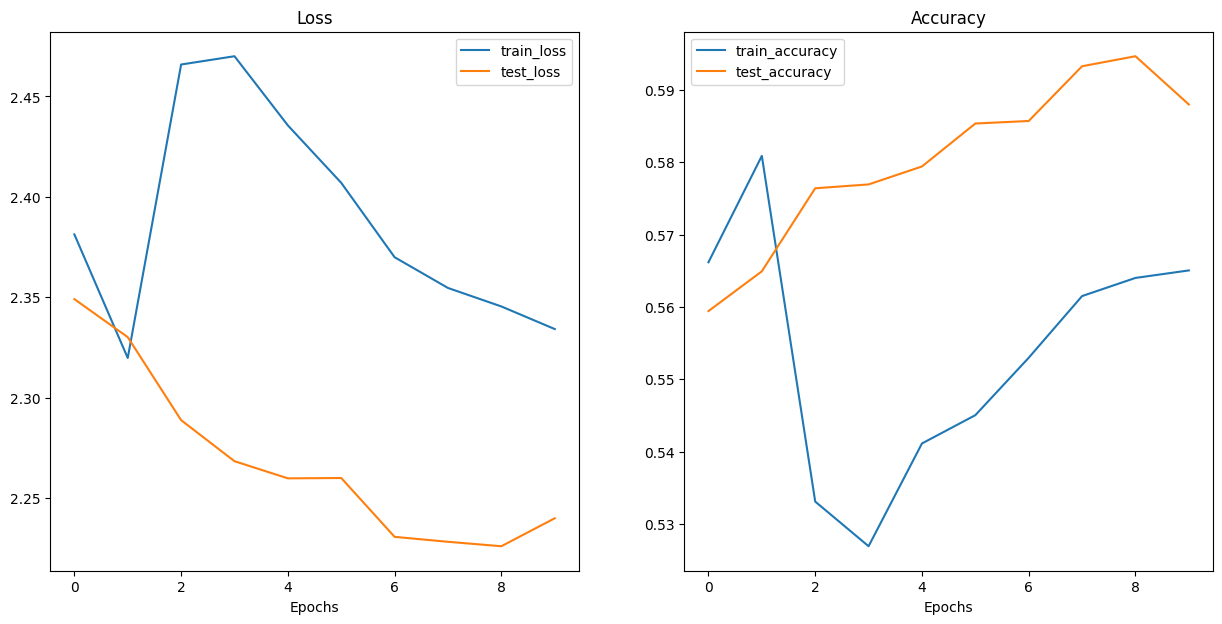

In [82]:
plot_loss_curves(effnetb2_food101_results)

## Save and load model

In [83]:
from going_modular.going_modular import utils

effnetb2_food101_model_path = "pretrained_effnetb2_food101_model.pth"

utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/pretrained_effnetb2_food101_model.pth


In [85]:
# Create Food101 cinstance

loaded_effnetb2_food101, effnetb2_transforms  = create_effnetb2_model(num_classes=101)

#Load the saved model's state_dict

loaded_effnetb2_food101.load_state_dict(torch.load("models/pretrained_effnetb2_food101_model.pth"))

<All keys matched successfully>

In [86]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


## Let's deploy it

In [88]:
from pathlib import Path


demo_path = Path("demos/foodvision101/")


demo_path.mkdir(parents=True, exist_ok=True)

(demo_path/ "examples").mkdir(parents=True, exist_ok=True)

In [89]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision101/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/pretrained_effnetb2_food101_model.pth demos/foodvision101

--2025-06-25 01:46:07--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.01s   

2025-06-25 01:46:08 (255 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



In [90]:
foodvision101_classnames_path = demo_path / "class_names.txt"
foodvision101_classnames_path

PosixPath('demos/foodvision101/class_names.txt')

In [91]:
with open(foodvision101_classnames_path, "w") as f:
  print(f"[INFO] Saving Food101 class names to {foodvision101_classnames_path}")
  f.write("\n".join(food101_class_names))

[INFO] Saving Food101 class names to demos/foodvision101/class_names.txt


In [96]:
# Let's now read the classnames of the file into a list

with open(foodvision101_classnames_path, "r") as f:
  print(f"[INFO] Reading Food101 class names from {foodvision101_classnames_path}")
  class_names_loaded = [food.strip() for food in f.readlines()]


[INFO] Reading Food101 class names from demos/foodvision101/class_names.txt


In [98]:
%%writefile demos/foodvision101/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Overwriting demos/foodvision101/model.py


In [100]:
## Imports
%%writefile demos/foodvision101/app.py

import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

with open("class_names.txt", "r") as f:
  class_names = [food_name.strip() for food_name in  f.readlines()]

  # Create model
  effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

  effnetb2.load_state_dict(
      torch.load(
          f="pretrained_effnetb2_food101_model.pth",
          map_location=torch.device("cpu")
      )
  )


  # Predict function

  # Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

# Gradio app

# Create title, and description


title = "FoodVision101 Classification with PyTorch and EfficientNetB2"
description = "An EfficientNetB2 feature extractor trained on the Food101 dataset."

# Create example inputs
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
)

# Launch the app!
demo.launch()


Writing demos/foodvision101/app.py


In [101]:
%%writefile demos/foodvision101/requirements.txt
torch==2.6.0
torchvision==0.21
gradio==5.31.0


Writing demos/foodvision101/requirements.txt


## Dowloading App Files



In [103]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision101 && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: app.py (deflated 57%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 56%)
  adding: pretrained_effnetb2_food101_model.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Deploying Our Larger Model